In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

import math
# import NormalizingFlows as NF
import torch.optim as optim

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints


class Flow(transform.Transform, nn.Module):

    def _inverse(self, y):
        pass

    def log_abs_det_jacobian(self, x, y):
        pass

    def _call(self, x):
        pass

    def __init__(self, event_dim = 1):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
        self._event_dim = event_dim

    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

    @property
    def event_dim(self):
        return self._event_dim

    @constraints.dependent_property(is_discrete=False)
    def domain(self):
        if self.event_dim == 0:
            return constraints.real
        return constraints.independent(constraints.real, self.event_dim)

    @constraints.dependent_property(is_discrete=False)
    def codomain(self):
        if self.event_dim == 0:
            return constraints.real
        return constraints.independent(constraints.real, self.event_dim)


class PlanarFlow(Flow):

    def _inverse(self, y):
        pass

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()


    def _call(self, x):
        f_x = F.linear(x, self.weight, self.bias)
        return x + self.scale * torch.tanh(f_x)

    def log_abs_det_jacobian(self, x, y = None):
        f_x = F.linear(x, self.weight, self.bias)
        psi = (1 - torch.tanh(f_x) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)


# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        self.on_cuda = torch.cuda.is_available()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
        if self.on_cuda:
            self.cuda()

    def forward(self, z):
        self.log_det = []
        if self.on_cuda:
            z = torch.tensor(z).detach().cuda()
        # Applies series of flows
        for b in range(len(self.bijectors)):
            log_det = self.bijectors[b].log_abs_det_jacobian(z)
            z = self.bijectors[b](z)
            if self.on_cuda:
                log_det = log_det.cuda()
                z = z.cuda()
            self.log_det.append(log_det)
        return z, self.log_det

    def sample(self):
        # dodać cude
        with torch.no_grad():
            base_dens_samples = self.base_density.sample()
            out_samples, _ = self.forward(base_dens_samples)
        return out_samples

    def log_prob(self, y):
        #dodać cude
        log_det_reversed_order = []
        for b in reversed(range(len(self.bijectors))):
            log_det_reversed_order.append(self.bijectors[b].log_abs_det_jacobian(y))
            y = self.bijectors[b]._inverse(y)
            print(y)
        log_prob_base = self.base_density.log_prob(y)
        jacobian_part = torch.sum(torch.stack(log_det_reversed_order))
        return log_prob_base - jacobian_part


class MaskedCouplingFlow(Flow):
    def __init__(self, dim, mask=None, n_hidden=64, n_layers=2, activation=nn.ReLU):
        super(MaskedCouplingFlow, self).__init__()
        self.k = dim // 2
        self.g_mu = self.transform_net(dim, dim, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(dim, dim, n_hidden, n_layers, activation)
        self.on_cuda = torch.cuda.is_available()
        if mask is None:
            front_back = torch.randint(2, (1,)).detach()
            if front_back < 0.5:
                self.register_buffer("mask",torch.cat((torch.ones(self.k), torch.zeros(self.k))).detach())
            else:
                self.register_buffer("mask", torch.cat((torch.zeros(self.k), torch.ones(self.k))).detach())
        else:
            self.register_buffer("mask", mask)
        self.init_parameters()
        self.bijective = True
        if self.on_cuda:
            self.cuda()

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            module = nn.Linear(l == 0 and nin or nhidden, l == nlayer - 1 and nout or nhidden)
            module.weight.data.uniform_(-1, 1)
            net.append(module)
            net.append(activation())
        return nn.Sequential(*net)

    def _call(self, x):
        x_k = (self.mask * x)
        xp_D = x * torch.exp(self.g_sig(x_k)) + self.g_mu(x_k)
        # xp_D = x * self.g_sig(x_k) + self.g_mu(x_k)

        return x_k + (1 - self.mask) * xp_D

    def _inverse(self, y):
        yp_k = (self.mask * y)
        y_D = (((1 - self.mask) * y) - (1 - self.mask) * (self.g_mu(yp_k)) / torch.exp(self.g_sig(yp_k)))
        # y_D = (((1 - self.mask) * y) - (1 - self.mask) * (self.g_mu(yp_k)) / self.g_sig(yp_k))

        return yp_k + y_D

    def log_abs_det_jacobian(self, x, y = None):
        return -torch.sum(torch.abs(self.g_sig(x * self.mask)))




In [3]:
class BatchNormFlow(Flow):
    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        self.on_cuda = torch.cuda.is_available()
        # Running batch statistics
        self.register_buffer('r_mean', torch.zeros(dim))
        self.register_buffer('r_var', torch.ones(dim))
        # Momentum
        self.register_buffer('momentum',torch.Tensor([momentum]))
        self.register_buffer('eps', torch.Tensor([eps]))

        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        if self.on_cuda:
            self.cuda()

        
    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            if self.on_cuda:
                self.b_mean = self.b_mean.cuda()
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        # add cuda
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        if self.on_cuda:
            mean = mean.cuda()
        # print(mean)
        # print(self.eps)

        var = torch.pow((z - mean), 2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

class ReverseFlow(Flow):

    def __init__(self, dim):
        super(ReverseFlow, self).__init__()
        self.permute = torch.arange(dim-1, -1, -1)
        self.inverse = torch.argsort(self.permute)
        
    def _call(self, z):
        return z[:, self.permute]

    def _inverse(self, z):
        return z[:, self.inverse]
    
    def log_abs_det_jacobian(self, z):
        return torch.zeros(z.shape[0], 1)

class AffineCouplingFlow(Flow):
    def __init__(self, dim, n_hidden=64, n_layers=3, activation=nn.ReLU):
        super(AffineCouplingFlow, self).__init__()
        self.k = dim // 2
        self.g_mu = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective = True

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(nn.Linear(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        z_k, z_D = z[:, :self.k], z[:, self.k:]
        zp_D = z_D * torch.exp(self.g_sig(z_k)) + self.g_mu(z_k)
        return torch.cat((z_k, zp_D), dim = 1)

    def _inverse(self, z):
        zp_k, zp_D = z[:, :self.k], z[:, self.k:]
        z_D = (zp_D - self.g_mu(zp_k)) / torch.exp(self.g_sig(zp_k))
        return torch.cat((zp_k, z_D))

    def log_abs_det_jacobian(self, z):
        z_k = z[:, :self.k]
        return -torch.sum(torch.abs(self.g_sig(z_k)))

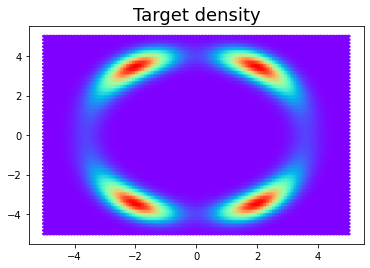

In [4]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

In [5]:

w1 = lambda z: torch.sin(2 * math.pi * z[:, 0] / 4)
w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
w3 = lambda z: 3 * (1.0 / (1 + torch.exp(-(z[:, 0] - 1) / 0.3)))

def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

def density_wave(z):
    z = torch.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    u = 0.5 * ((z2 - w1(z))/0.4) ** 2
    u[torch.abs(z1) > 4] = 1e8
    return torch.exp(-u)

In [6]:
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk)+1e-9)).mean()

In [7]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# block = [NF.MaskedCouplingFlow, BatchNormFlow]
block = [MaskedCouplingFlow]
block2 = [AffineCouplingFlow, ReverseFlow, BatchNormFlow]
block3 = [PlanarFlow]
flow = NormalizingFlow(dim = 2, blocks = block, flow_length = 32, density = ref_distrib)
# flow2 = NormalizingFlow(dim = 2, blocks = block2, flow_length = 32, density = ref_distrib)
# flow3 = NormalizingFlow(dim = 2, blocks = block3, flow_length = 16, density = ref_distrib)
# flow = NF.NormalizingFlow(dim =2, blocks = block2, flow_length = 16, density = ref_distrib)

In [8]:
def train_flow(flow, loss, optimizer, scheduler, target_density, epochs=10001, plot_it=1000, batch_size = 64):
    ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
    # ims = []
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    # fig = plt.figure(figsize=(10, 10))
    id_figure=2
    plt.figure(figsize=(16, 18))
    subplot_num = epochs // plot_it
    plt.subplot((subplot_num//4) + 1,4,1)
    plt.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    plt.title('Target density', fontsize=15);
    # Main optimization loop
    for it in range(epochs):
        # Draw a sample batch from Normal
        samples = ref_distrib.sample((batch_size, ))
        # Evaluate flow of transforms
        zk, log_jacobians = flow(samples)
        # Evaluate loss and backprop
        optimizer.zero_grad()
        loss_v = loss(target_density, zk, log_jacobians)
        loss_v.backward()
        optimizer.step()
        scheduler.step()
        if (it % plot_it == 0):
            print('Loss (it. %i) : %f'%(it, loss_v.item()))
            # Draw random samples
            samples = ref_distrib.sample((int(1e5), ))
            # Evaluate flow and plot
            zk, _ = flow(samples)
            zk = zk.detach().cpu().numpy()
            plt.subplot((subplot_num//4) + 1,4,id_figure)
            plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
            plt.title('Iter.%i'%(it), fontsize=15);
            id_figure += 1
    #ax1.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
    #ax1.set_title('Target density', fontsize=15);
    #ax2.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
    #ax2.set_title('Final approximation', fontsize=15)

In [9]:
# with torch.no_grad():
    # torch.cuda.empty_cache()

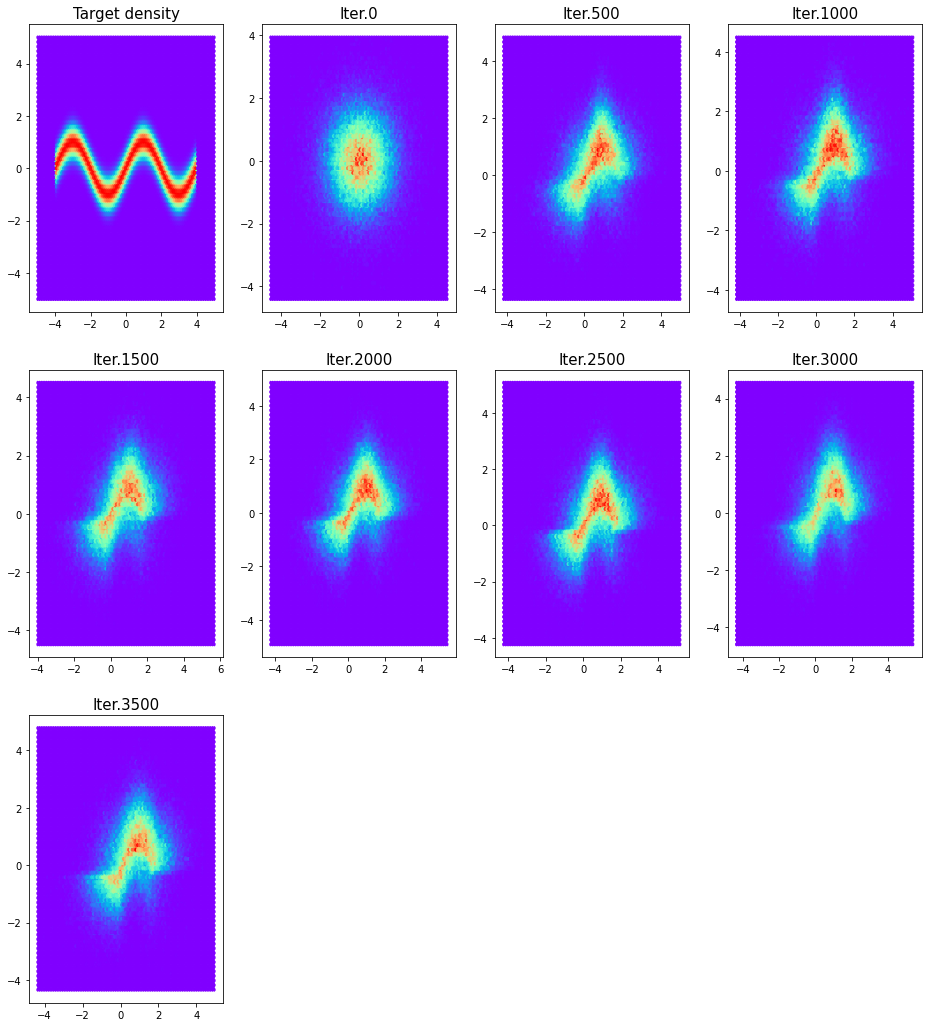

In [10]:
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch the optimization
train_flow(flow, loss, optimizer, scheduler, density_wave, epochs=10000, plot_it=500)

In [ ]:
for a, b in flow.bijectors[0].named_buffers():
    print(a,b)